# Mask R-CNN Demo

### Environment Setup

In [3]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import imgaug
from imgaug import augmenters as iaa

# Root directory of the project
ROOT_DIR = os.path.abspath("../../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
import mrcnn.model as modellib
from mrcnn.model import log

from samples.whales import whale

import numpy.ma as ma
import scipy.misc

import numpy as np
import matplotlib.pyplot as plt
import skimage.filters

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

/home/clifgray/anaconda3/envs/maskrcnn/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### Model and dataset setup

In [4]:
#sets up the system and generates masks
# Root directory of the project
ROOT_DIR = os.path.abspath("../../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
%matplotlib inline 

# Path to trained weights
#WHALE_WEIGHTS_PATH = "/home/clifgray/Code/Mask_RCNN/logs/whale20180613T0247/mask_rcnn_whale_0075.h5"

config = whale.WhaleConfig()
WHALE_DIR = os.path.join(ROOT_DIR, "datasets/whale_training/blue")
# Override the training configurations with a few
# changes for inferencing.
class InferenceConfig(config.__class__):
# Run detection on one image at a time
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()
#config.display()

# Device to load the neural network on.
# Useful if you're training a model on the same 
# machine, in which case use CPU and leave the
# GPU for training.
DEVICE = "/gpu:0"  # /cpu:0 or /gpu:0

# Inspect the model in training or inference modes
# values: 'inference' or 'training'
# TODO: code for 'training' test mode not ready yet
TEST_MODE = "inference"

# Load validation dataset
dataset = whale.WhaleDataset()
dataset.load_whale(WHALE_DIR, "test")
#
# Must call before using the dataset
dataset.prepare()

print("Images: {}\nClasses: {}".format(len(dataset.image_ids), dataset.class_names))


#Getting manually drawn masks
id_array = np.arange(len(dataset.image_ids)) #17 images in this set
mask_array = []
for num in id_array:
    image_id = num

    image, image_meta, class_ids, bbox, mask = modellib.load_image_gt(dataset, config, image_id, use_mini_mask=False)
    info = dataset.image_info[image_id]
   # if image_id >= 19 and image_id <= 35:
    mask_array.append(mask)


Images: 17
Classes: ['BG', 'Balaenoptera_musculus_body', 'Balaenoptera_musculus_pectoral']


In [5]:
def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

### Function for Whale Masking

In [6]:
def run_cnn(weights_path="/home/clifgray/Code/Mask_RCNN/logs/whale20180613T0247/mask_rcnn_whale_0150.h5"):
    # Create model in inference mode
    with tf.device(DEVICE):
        model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR,
                              config=config)
        
    # Load weights
    print("Loading weights ", weights_path)
    model.load_weights(weights_path, by_name=True)
    print("Weights loaded.")
    
    
    detection_results = []
    initial_time = time.perf_counter()
    for image_id in dataset.image_ids:
    
        image, image_meta, gt_class_id, gt_bbox, gt_mask =\
            modellib.load_image_gt(dataset, config, image_id, use_mini_mask=False)

        info = dataset.image_info[image_id]

        # Run object detection
        results = model.detect([image], verbose=0)
        
        detection_results.append([results, info, image_id])
        print("Done detecting and masking image #:  " + str(len(detection_results)))
    
    finish_time = time.perf_counter()
    time_elapsed = finish_time - initial_time
    print("\n")
    print(time_elapsed, "seconds elapsed while masking", len(detection_results), "images.")
    print((time_elapsed/len(detection_results), "seconds per image."))
    
    return detection_results



### Run detection and masking

In [ ]:
detection_results = run_cnn()

Loading weights  /home/clifgray/Code/Mask_RCNN/logs/whale20180613T0247/mask_rcnn_whale_0150.h5


### Look at an example mask

In [ ]:
results_object = detection_results[9]
image_id = results_object[2]
info = results_object[1]

image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset, config, image_id, use_mini_mask=False)

print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, 
                                       dataset.image_reference(image_id)))

results = results_object[0]

# Display results
ax = get_ax(1)
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            dataset.class_names, r['scores'], ax=ax,
                            title="Predictions")
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

# Measuring from the Mask

In [ ]:
#After run through NN, each image could have multiple masks
def find_correct_mask(mask): 
    #Find which mask to use - one with the largest number of pixels
    # TODO change this to choosing the ones with the body label
    numOfMasks = np.size(mask, 2)
    i = 0
    pixcount = 0
    pixCountArray = []
    while i < numOfMasks:
        currentMask = (mask[:, :, i])
        pixcount = 0
        nonzero = np.nonzero(currentMask)
        it2 = np.nditer(currentMask, flags =['multi_index'])
        while not it2.finished:
            if it2[0] == True:
                pixcount = pixcount + 1
            it2.iternext()
        pixCountArray.append(pixcount)
        i = i+1

#Find max in pixCountArray - gets the biggest mask that will be the body
    correctIndex = pixCountArray.index(max(pixCountArray))
    body = (mask[:,:,correctIndex])
    return body

In [ ]:
def pca(body, boolean):
    xy_array = []
 # get indexes of mask pixels
    y, x = np.nonzero(body)
    
# mean center the coords
    x = x - np.mean(x)
    y = y - np.mean(y)
    coords = np.vstack([x, y])

# build covariance matreix and eigenvectors
    cov = np.cov(coords)
    evals, evecs = np.linalg.eig(cov)
    
# sort eigenvalues
    sort_indices = np.argsort(evals)[::-1]
    x_v1, y_v1 = evecs[:, sort_indices[0]]  # Eigenvector with largest eigenvalue
    x_v2, y_v2 = evecs[:, sort_indices[1]]

    
    if boolean == True:
# plot the major and minor axis of the whale mask
        scale = 20
        plt.plot(x, y, 'k.')

        plt.plot([x_v1*-scale*2, x_v1*scale*2],
         [y_v1*-scale*2, y_v1*scale*2], color='red')
        plt.plot([x_v2*-scale, x_v2*scale],
         [y_v2*-scale, y_v2*scale], color='blue')
        plt.axis('equal')
        plt.gca().invert_yaxis()  # Match the image system with origin at top left
        plt.show()

# orient this along the horizontal axis
    theta = np.tanh((x_v2)/(y_v2))  
    rotation_mat = np.matrix([[np.cos(theta), -np.sin(theta)],
                      [np.sin(theta), np.cos(theta)]])
    transformed_mat = rotation_mat * coords
# plot the transformed blob
#these are the final transformed coords
    x_transformed, y_transformed = transformed_mat.A

    maxX = np.max(x_transformed)
    minX = np.min(x_transformed)
    maxY = np.max(y_transformed)
    minY = np.min(y_transformed)


#Get corresonding Y values for minX and maxX
    maxX_index = np.where(x_transformed == maxX) #index of right-most point
    rightY = float((y_transformed[maxX_index])) #corresponding Y value


    minX_index = np.where(x_transformed == minX) #index of left-most point
    leftY = float((y_transformed[minX_index])) #corresponding Y value
    
#Orient the mask correctly - flip so the fluke is on the right

#Get corresonding X values for maxY and minY

    maxY_index = np.where(y_transformed == maxY) #index of top point
    topX = float((x_transformed[maxY_index])) #corresponding X value


    minY_index = np.where(y_transformed == minY) #index of bottom point
    bottomX = float((x_transformed[minY_index])) #corresponding X value

    #Flip mask so fluke is on the right, if necessary
    if (topX < 0 or bottomX < 0):
        x_transformed = x_transformed*-1 
    
    xy_array = [x_transformed, y_transformed]
    
    
    return xy_array


In [ ]:
def measure(results_list):
    length_list = []

    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset, config, image_id, use_mini_mask=False)
    
    for item in results_list:
        if np.array_equal(results_list, detection_results):
            mask = item[0][0]["masks"]
        else:
            mask = item
            
        body = find_correct_mask(mask) #Ignore pectoral masks
        xy_array = pca(body, False) #PCA
        x_transformed = xy_array[0]
        y_transformed = xy_array[1]
        
        #Reassign max/min X values in case image was flipped during PCA

        maxX = np.max(x_transformed) #rightX
        minX = np.min(x_transformed) #leftX

#Get corresonding Y values for leftX and rightX

        maxX_index = np.where(x_transformed == maxX) #index of right-most point
        rightY = float((y_transformed[maxX_index])) #corresponding Y value


        minX_index = np.where(x_transformed == minX) #index of left-most point
        leftY = float((y_transformed[minX_index])) #corresponding Y value
        
#Get points from leftX and rightX until it runs off the mask

#Filter out points above straight line 
#Arbitrary lambda, might need to change later
        lowEnough = list(filter(lambda y: y < (leftY + 0.5), y_transformed))
        yValues = list(filter(lambda y: y > (leftY - 0.5), lowEnough)) 
        yValues.sort()

#Get corresponding X values
#List of appropriate indices
        indices = []
        for point in yValues:
            index = int(np.where(y_transformed == point)[0])
            indices.append(index)
    
        xValues = [] #Corresponding X values
        for index in indices:
            xValues.append(x_transformed[index]) 

        xValues.sort()


        length = math.sqrt((xValues[-1] - xValues[0])**2 + (yValues[-1] - yValues[0])**2)
        
        if np.array_equal(results_list, detection_results):
            item.append(length)
        else:
            length_list.append(length)
        
        
      
    return length_list
    

In [ ]:
def show_example(whale_list, index):
    
    image_id = index
    
    image, image_meta, class_ids, bbox, mask = modellib.load_image_gt(
        dataset, config, image_id, use_mini_mask=False)
    log("molded_image", image)
    log("mask", mask)
    print("mask.shape", mask.shape)
    
    item = whale_list[index]
    if np.array_equal(whale_list, detection_results):
        mask = item[0][0]["masks"]
    else:
        mask = item 

    visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names, show_bbox=False)
    

    length_list = []

    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset, config, image_id, use_mini_mask=False)
    
    body = find_correct_mask(mask)
    xy_array = pca(body, True)
    x_transformed = xy_array[0]
    y_transformed = xy_array[1]
        #Reassign max/min X values in case image was flipped

    maxX = np.max(x_transformed) #rightX
    minX = np.min(x_transformed) #leftX
    
#Get corresonding Y values for leftX and rightX

    maxX_index = np.where(x_transformed == maxX) #index of right-most point
    rightY = float((y_transformed[maxX_index])) #corresponding Y value


    minX_index = np.where(x_transformed == minX) #index of left-most point
    leftY = float((y_transformed[minX_index])) #corresponding Y value
        
        
#Get points from leftX and rightX until it runs off the mask

#Filter out points above straight line 
#Arbitrary lambda, might need to change later
    lowEnough = list(filter(lambda y: y < (leftY + 0.5), y_transformed))
    yValues = list(filter(lambda y: y > (leftY - 0.5), lowEnough)) 
    yValues.sort()

#Get corresponding X values
#List of appropriate indices
    indices = []
    for point in yValues:
        index = int(np.where(y_transformed == point)[0])
        indices.append(index)
    
    xValues = [] #Corresponding X values
    for index in indices:
        xValues.append(x_transformed[index]) 

    xValues.sort()

    length = math.sqrt((xValues[-1] - xValues[0])**2 + (yValues[-1] - yValues[0])**2)
    length_list.append(length)
        
    if np.array_equal(whale_list, detection_results): #CNN Masks, length is appended to object
        item.append(length)

    #plt.plot(x_transformed, y_transformed, alpha = 0.5)
    plt.plot(x_transformed, y_transformed, 'g.', zorder=0)
    
    # set axis limits
    plt.xlim([minX - 100, maxX + 100])
    plt.ylim([leftY - 200, rightY + 200])
    
    #Plot the first and last points from the list, use this for length
    
    #plt.scatter(xValues[0], yValues[0], zorder=10)
    #plt.scatter(xValues[-1], yValues[-1], zorder=10)
    plt.scatter(xValues, yValues, zorder=10)
    plt.show()
    
    
show_example(mask_array, 3)

In [ ]:
measure(detection_results) #CNN appends length 

In [ ]:
manual_mask_lengths = measure(mask_array) #Manual Masks can't append
print(manual_mask_lengths)

In [35]:
excel_measurements = pd.read_excel("NSF-IOS_2017Measurements_kcb_updated_062018.xlsx")
blue_measurements = excel_measurements.loc[excel_measurements["Whale"].str.contains("Bm")]
blue_measurements = blue_measurements.reset_index(drop=True)

# imaged were downsized from 6000 as a max dimension to 1024 as a max dimension so pixels are 5x as large in meters
pixel_size_factor = 6000.0 / 1024.0

measurements_df = pd.DataFrame(np.nan, index=np.arange(0, len(blue_measurements)), columns=['Filename', 'Auto_CNN_Measurements', 'Manual_Mask_Measurements', 'Manual_Standard_Measurements', 'Estimated_Manual_Error'])

#measurements_df.set_index("Filename")

for index, row in blue_measurements.iterrows():
    cnn_pixel_count = 0
    percent_error = 0
    manual_pixel_count = 0
    
    for whale in detection_results: #CNN Masks
        if whale[1]['id'] == (row['Image']):
            cnn_pixel_count = whale[3]
            
        adjusted_cnn_pixel_count = cnn_pixel_count * pixel_size_factor

    # TODO need to make this more robust, might not match the correct index at some point
    adjusted_manual_pixel_count = manual_mask_lengths[index] * pixel_size_factor #Manual Masks
    
    total_altitude = row["Total Altitude"]
    pixel_size = row["Pixel size"]
    focal_length = row["Focal length (mm)"] #always 5
    
  
    
        
    measurements_df.loc[measurements_df.index[index], "Filename"] = row["Image"]
    measurements_df.loc[measurements_df.index[index], "Auto_CNN_Measurements"] = adjusted_cnn_pixel_count * pixel_size/focal_length * total_altitude
    measurements_df.loc[measurements_df.index[index], "Manual_Mask_Measurements"] = adjusted_manual_pixel_count * pixel_size/focal_length * total_altitude
    measurements_df.loc[measurements_df.index[index], "Manual_Standard_Measurements"] = row["Total Length (m)"]
    
    measurements_df.loc[measurements_df.index[index], "Estimated_Manual_Error"] = row["Estimated % Error"]
    
    # Percent error
    #percent_error = abs(measurements_df["Auto_CNN_Measurement"][index] - measurements_df["Manual_Standard_Measurement"][index])/measurements_df["Manual_Standard_Measurement"][index]*100
    #measurements_df.loc[measurements_df.index[index], "Auto_Percent_Error"] = percent_error

measurements_df

Filename  Auto_CNN_Measurements  Manual_Mask_Measurements  \
0   DSC02689.JPG              21.804893                 22.374149   
1   DSC03182.JPG              20.033111                 20.302168   
2   DSC03206.JPG              21.853873                 22.044852   
3   DSC03331.JPG              21.965600                 22.510574   
4   DSC03665.JPG              21.527112                 21.810883   
5   DSC03795.JPG              21.168680                 21.409063   
6   DSC03868.JPG              22.123516                 22.435906   
7   DSC03996.JPG              20.620096                 21.121444   
8   DSC04067.JPG              22.537984                 22.818857   
9   DSC04110.JPG              21.053401                 21.411126   
10  DSC04216.JPG              23.458032                 24.055277   
11  DSC04331.JPG              21.065048                 21.246789   
12  DSC04475.JPG              21.709495                 24.173879   
13  DSC04471.JPG              23.929808                 22.283291   
14  DSC04596.JPG              22.324800                 21.371634   
15  DSC04565.JPG              19.445489                 21.518875   
16  DSC04578.JPG              21.111615                 22.869736   

    Manual_Standard_Measurements  Estimated_Manual_Error  
0                      22.528405                  0.0004  
1                      20.304210                  0.0074  
2                      22.358987                  0.0074  
3                      22.456202                  0.0074  
4                      22.139630                  0.0004  
5                      21.639458                  0.0004  
6                      22.547801                  0.0004  
7                      21.056910                  0.0074  
8                      22.929705                  0.0074  
9                      21.357748                  0.0074  
10                     24.120341                  0.0074  
11                     21.207847                  0.0074  
12                     21.867586                  0.0074  
13                     24.428231                  0.0074  
14                     22.954157                  0.0074  
15                     21.638016                  0.0074  
16                     21.846274                  0.0074

#### Differences in Conventional Measurements vs CNN Derived Measurements

In [36]:
std_auto_diff = measurements_df["Manual_Standard_Measurements"] - measurements_df["Auto_CNN_Measurements"]
print("Max difference", max(std_auto_diff))
print("Min difference", min(std_auto_diff))
print("Avg difference", std_auto_diff.mean())

Max difference 2.192527870275484
Min difference 0.14279880990366678
Avg difference 0.5675856019028773


#### Differences in Conventional Measurements vs Manual Mask Derived Measurements

In [37]:
std_man_diff = measurements_df["Manual_Standard_Measurements"] - measurements_df["Manual_Mask_Measurements"]
print("Max difference", max(std_man_diff))
print("Min difference", min(std_man_diff))
print("Avg difference", std_man_diff.mean())

Max difference 2.1449404539900208
Min difference -2.3062929091145214
Avg difference 0.0954710027597535


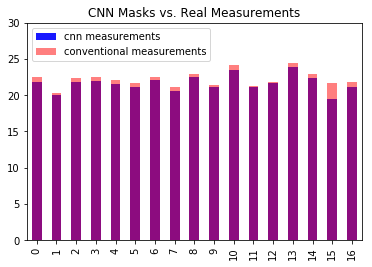

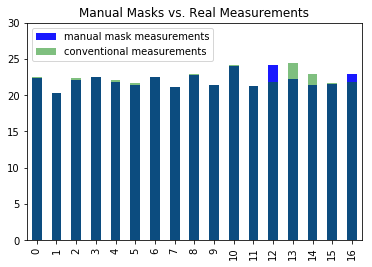

In [38]:
# Histograms comparing lengths

plt.figure()
plt.ylim(0, 30)

measurements_df["Auto_CNN_Measurements"].plot.bar(stacked = True, alpha = 0.9, color = 'b', label = "cnn measurements", title="CNN Masks vs. Real Measurements")
measurements_df["Manual_Standard_Measurements"].plot.bar(stacked = True, alpha = 0.5, color = "r", label = "conventional measurements")
plt.legend(loc='upper left')
plt.show()


plt.figure()
plt.ylim(0, 30)
measurements_df["Manual_Mask_Measurements"].plot.bar(stacked = True, alpha = 0.9, color = 'b', label="manual mask measurements", title="Manual Masks vs. Real Measurements")
measurements_df["Manual_Standard_Measurements"].plot.bar(stacked = True, alpha = 0.5, color = "g", label = "conventional measurements")
plt.legend(loc='upper left')
plt.show()



<Figure size 432x288 with 0 Axes>

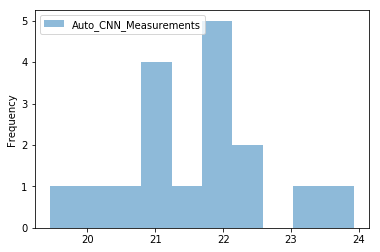

<Figure size 432x288 with 0 Axes>

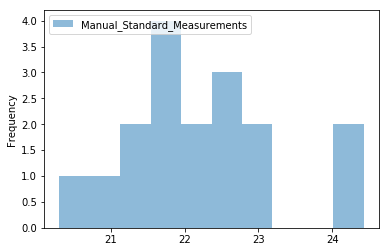

In [39]:
measurement_series = measurements_df.loc[:, measurements_df.columns == 'Auto_CNN_Measurements']
plt.figure()
#plt.ylim(0,10)
measurement_series.plot.hist(stacked=True, bins=10, alpha=0.5)
plt.legend(loc=2)
plt.show()

measurement_series = measurements_df.loc[:, measurements_df.columns == 'Manual_Standard_Measurements']
plt.figure()
#plt.ylim(0,10)
measurement_series.plot.hist(stacked=True, bins=10, alpha=0.5)
plt.legend(loc=2)
plt.show()



molded_image             shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
mask                     shape: (1024, 1024, 3)       min:    0.00000  max:    1.00000  bool
mask.shape (1024, 1024, 3)


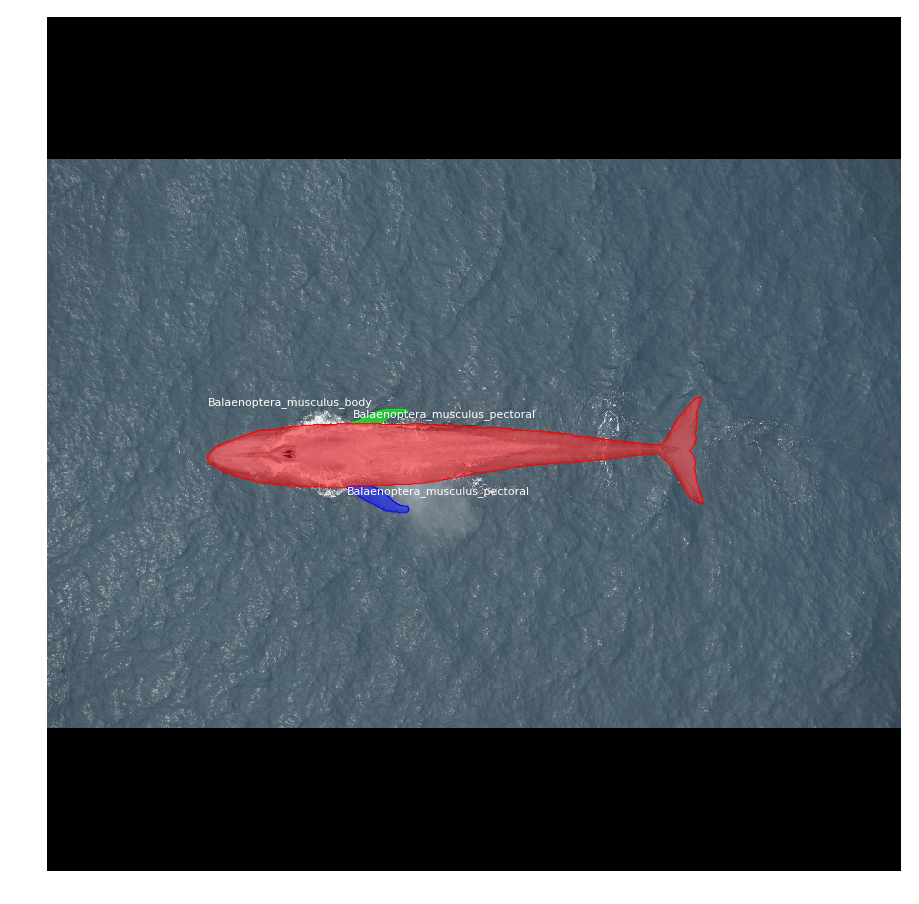

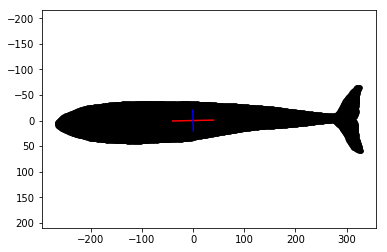

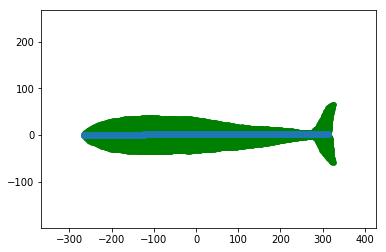

In [40]:
show_example(mask_array, 12)

molded_image             shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
mask                     shape: (1024, 1024, 1)       min:    0.00000  max:    1.00000  bool
mask.shape (1024, 1024, 1)


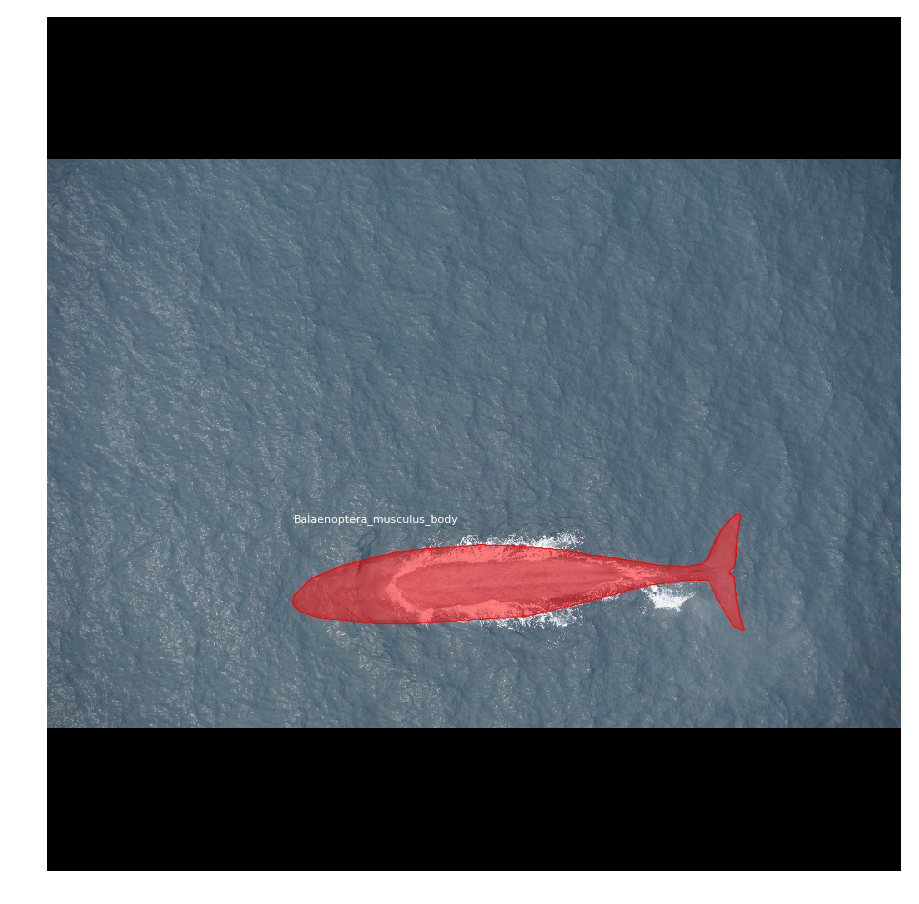

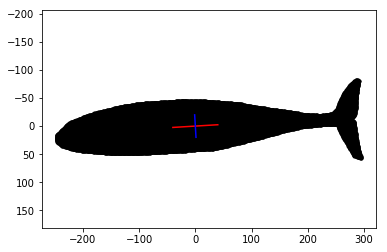

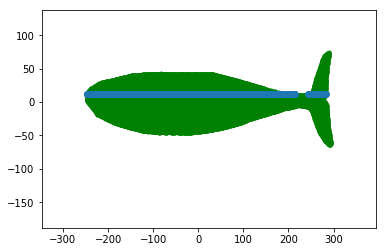

In [41]:
show_example(mask_array, 13)

molded_image             shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
mask                     shape: (1024, 1024, 3)       min:    0.00000  max:    1.00000  bool
mask.shape (1024, 1024, 3)


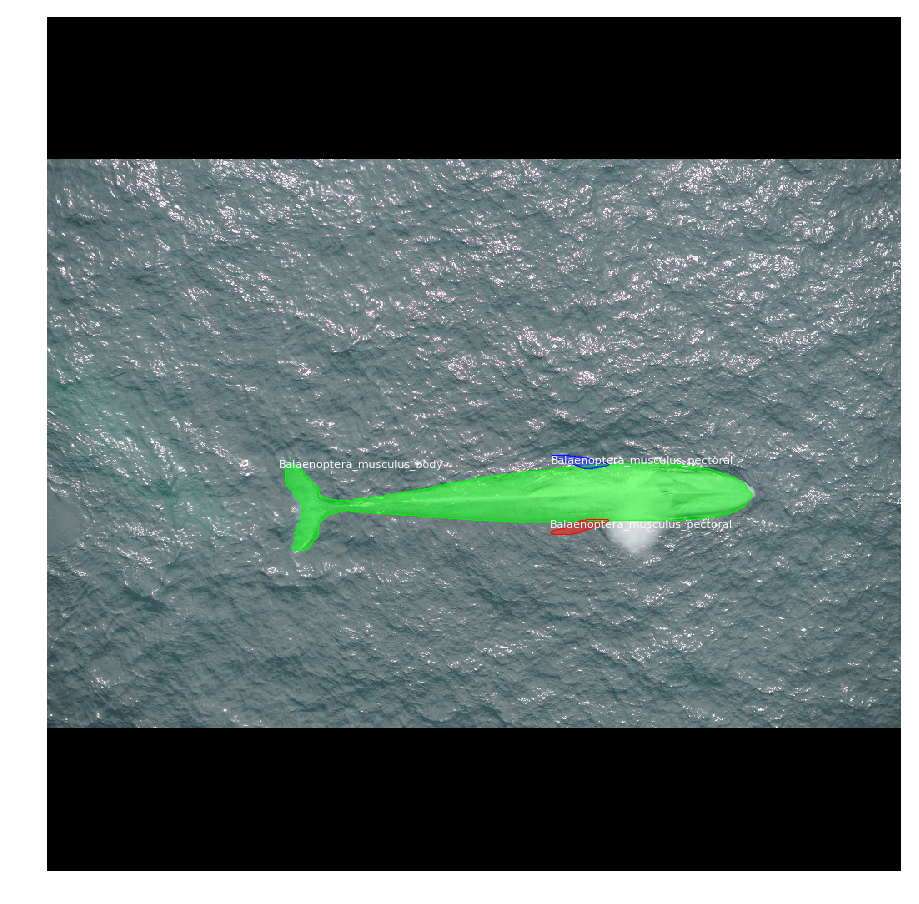

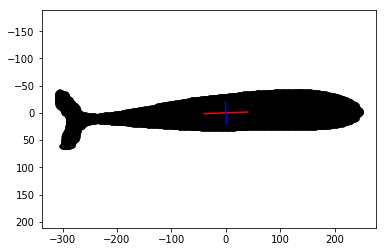

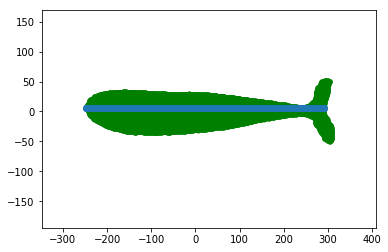

In [42]:
show_example(detection_results, 15)